## FSP Survey Insights

In [1]:
# import math, os, re, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm

from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
pd.set_option('display.max_columns', 50)

In [2]:
df = pd.read_csv('survey_data2.csv', skiprows=list(range(1,6)))

df = df.loc[:,'Progress':].copy()
df = pd.concat([df.loc[:, :'RecordedDate'], df.loc[:, 'Q1':]], axis=1)

df.rename(columns={'Progress':'progress',
                   'Duration (in seconds)':'duration_seconds',
                   'Finished':'finished',
                   'RecordedDate':'date_recorded',
                   'Q1':'age',
                   'Q2':'gender',
                   'Q3':'highest_education',
                   'Q4':'annual_income',
                   'Q5':'willingness_to_purchase_secondhand',
                   'Q6':'purchased_secondhand_before',
                   'Q7':'purchase_secondhand_from',
                   'Q8':'other_secondhand_sources',
                   'Q9':'secondhand_mover_channel',
                   'Q10':'other_secondhand_mover_channels',
                   'Q11_1':'ranked_branding',
                   'Q11_2':'ranked_punctuality',
                   'Q11_3':'ranked_value_added_services',
                   'Q11_4':'ranked_insurance_security',
                   'Q11_5':'ranked_trained_employees',
                   'Q11_6':'ranked_web_ui_advertising',
                   'Q11_7':'ranked_vehicle_type',
                   'Q11_8':'ranked_good_reviews',
                   'Q11_9':'ranked_response_speed',
                   'Q12_1':'additional_amount_for_quality',
                   'Q13':'other_quality_services',
                   'Q14_1':'additional_amount_for_other_quality',
                   'Q15':'email'}, inplace=True)  

df.dropna(how='all', subset=[col for col in df.columns if col.startswith('ranked')], inplace=True)
df.reset_index(drop=True, inplace=True)

for col in [c for c in df.columns if c.startswith('ranked')]:
    df[col] = df[col].apply(lambda x: int(x))

df['date_recorded'] = pd.to_datetime(df['date_recorded'])

for col in ['age']:
    df[col] = df[col].astype(np.int64)

pd.concat([pd.DataFrame(df.isna().sum(), columns=['missing_vals']), 
           pd.DataFrame(df.dtypes, columns=['dtype'])], axis=1)

,missing_vals,dtype
progress,0,int64
duration_seconds,0,int64
finished,0,bool
date_recorded,0,datetime64[ns]
age,0,int64
gender,0,object
highest_education,0,object
annual_income,0,object
willingness_to_purchase_secondhand,0,object
purchased_secondhand_before,0,object


In [3]:
### Lucky Draw
# lucky_draw = list(set([email for email in list(df.email.value_counts().index) if '@' in email]))

# print(len(lucky_draw), '\n', lucky_draw)

# for i in range(10):
#     print(lucky_draw[np.random.randint(len(lucky_draw))])

In [4]:
df

,progress,duration_seconds,finished,date_recorded,age,gender,highest_education,annual_income,willingness_to_purchase_secondhand,purchased_secondhand_before,purchase_secondhand_from,other_secondhand_sources,secondhand_mover_channel,other_secondhand_mover_channels,ranked_branding,ranked_punctuality,ranked_value_added_services,ranked_insurance_security,ranked_trained_employees,ranked_web_ui_advertising,ranked_vehicle_type,ranked_good_reviews,ranked_response_speed,additional_amount_for_quality,other_quality_services,additional_amount_for_other_quality,email
0,100,180,True,2020-09-09 10:41:00,35,Male,PhD,"More than 150,000",Maybe,Yes,Facebook,NaN,Facebook,NaN,7,4,1,5,2,8,6,3,9,30.0,Communication,NaN,NaN
1,100,111,True,2020-09-09 19:16:00,33,Male,Masters,"100,000 - 150,000",Maybe,Yes,Carousell,NaN,Carousell,NaN,4,5,3,6,7,8,2,1,9,9.0,NaN,NaN,NaN
2,100,87,True,2020-09-14 01:19:00,24,Male,Bachelors,"Less than 20,000",No,No,Thrift Shops (e.g. Salvation Army),NaN,Word of Mouth,NaN,9,1,7,3,2,6,4,5,8,5.0,No damage to furniture,10.0,chongkiat.ang@u.nus.edu
3,100,110,True,2020-09-14 01:20:00,21,Male,Polytechnic (Diploma) / Junior College (A-Levels),"Less than 20,000",Yes,Yes,"Thrift Shops (e.g. Salvation Army),Word of Mouth",NaN,"Carousell,Word of Mouth",NaN,5,3,1,6,7,8,9,4,2,9.0,Tracking services,5.0,aloysiuschan.80@gmail.com
4,100,113,True,2020-09-14 01:20:00,22,Male,Polytechnic (Diploma) / Junior College (A-Levels),"Less than 20,000",No,No,"Thrift Shops (e.g. Salvation Army),Word of Mouth",NaN,"Instagram,Word of Mouth",NaN,7,8,3,2,6,9,4,1,5,20.0,-,0.0,hotingzhang@u.nus.edu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,100,245,True,2020-09-28 08:42:00,22,Female,Polytechnic (Diploma) / Junior College (A-Levels),"Less than 20,000",Maybe,No,"Carousell,Thrift Shops (e.g. Salvation Army)",NaN,Gumtree,NaN,7,5,6,1,3,4,9,2,8,15.0,Can't think of any,0.0,NaN
187,100,302,True,2020-09-28 23:55:00,23,Male,Polytechnic (Diploma) / Junior College (A-Levels),"Less than 20,000",Yes,Yes,Word of Mouth,NaN,Word of Mouth,NaN,3,6,7,2,1,8,9,4,5,10.0,NaN,NaN,e0202649@u.nus.edu
188,100,192,True,2020-09-29 00:17:00,23,Male,Polytechnic (Diploma) / Junior College (A-Levels),"Less than 20,000",Maybe,Yes,"Carousell,Word of Mouth",NaN,Carousell,NaN,7,2,6,1,3,8,9,4,5,1.0,Notifications on pick up and arrival,0.0,Clemxsin001@gmail.com
189,93,447,False,2020-09-29 05:15:00,56,Female,Polytechnic (Diploma) / Junior College (A-Levels),"80,000 - 100,000",Maybe,No,"Carousell,Thrift Shops (e.g. Salvation Army)",NaN,Carousell,NaN,9,4,1,6,2,8,5,3,7,2.0,NaN,NaN,NaN


### Survey Participant Visualization

#### Demographics

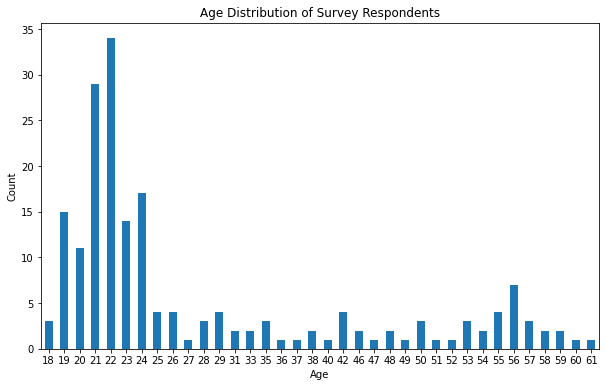

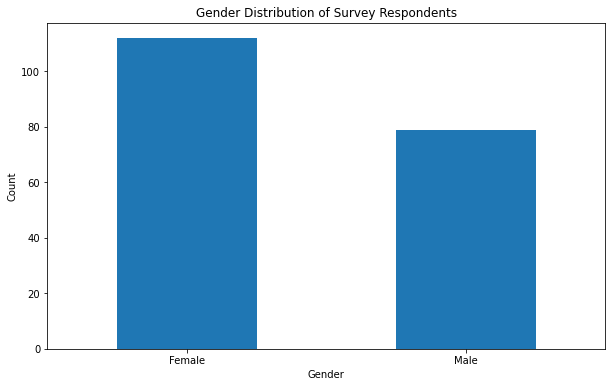

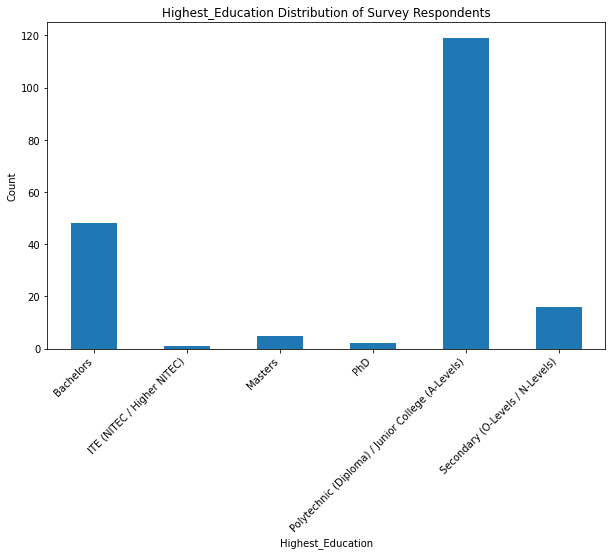

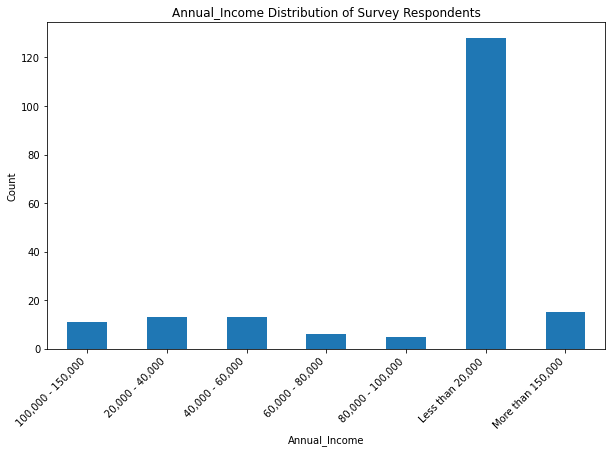

In [5]:
# Demographics Visualization
for col in ['age', 'gender', 'highest_education', 'annual_income']:
    plt.figure(figsize=(10,6))

    df[col].value_counts().sort_index().plot.bar()
    plt.title(col.title() + ' Distribution of Survey Respondents')
    plt.xlabel(col.title())
    plt.ylabel('Count')
    
    if col in ['highest_education', 'annual_income']:
        plt.xticks(rotation=45, horizontalalignment='right')
    else:
        plt.xticks(rotation=0, horizontalalignment='center')

    plt.show()

### Gender
# 1: Male
# 2: Female

### Education Level
# 1: Secondary (O-Levels / N-Levels)
# 2: Polytechnic (Diploma) / Junior College (A-Levels)
# 3: ITE (NITEC / Higher NITEC)
# 4: Bachelors
# 5: Masters
# 6: PhD

### Income Level
# 1: Less than 20,000
# 2: 20,000 - 40,000
# 3: 40,000 - 60,000
# 4: 60,000 - 80,000
# 5: 80,000 - 100,000
# 6: 100,000 - 150,000
# 7: More than 150,000

#### Secondhand Furniture Experience & History

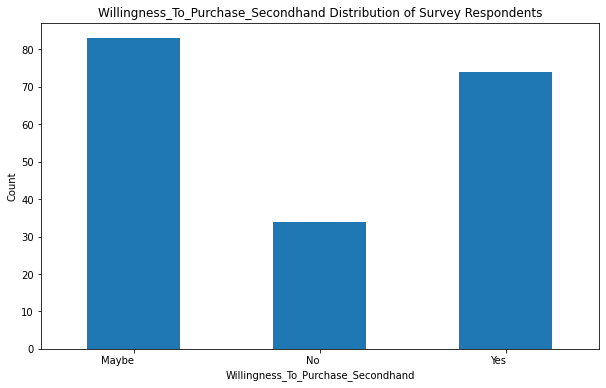

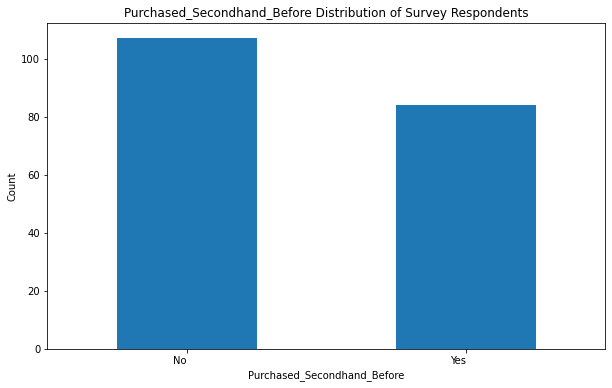

In [6]:
for col in ['willingness_to_purchase_secondhand','purchased_secondhand_before']:
    plt.figure(figsize=(10,6))

    df[col].value_counts().sort_index().plot.bar()
    plt.title(col.title() + ' Distribution of Survey Respondents')
    plt.xlabel(col.title())
    plt.ylabel('Count')
    plt.xticks(rotation=0, horizontalalignment='right')

    plt.show()
    
### Willingness to purchase Second Hand Furniture
# 1: Yes
# 2: Maybe
# 3: No

### Purchased Second Hand Furniture Before
# 1: Yes
# 2: No

#### Understanding of Secondhand Furniture

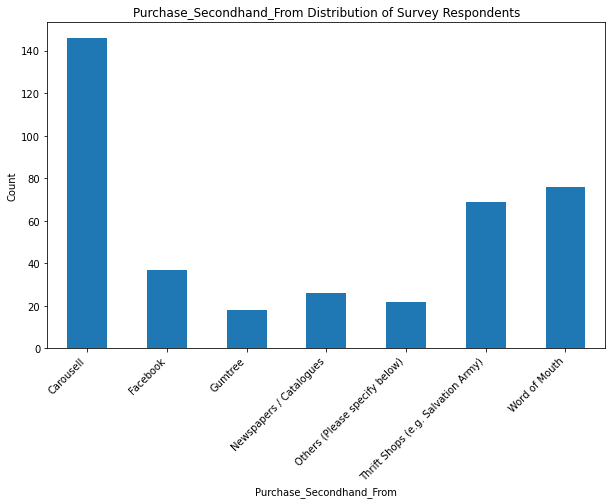

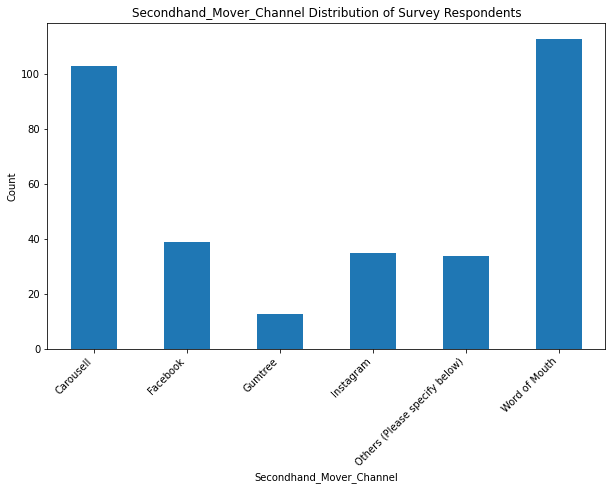

In [7]:
for col in ['purchase_secondhand_from', 'secondhand_mover_channel']:
    all_values = []

    for item in df[col].values:
        all_items = item.split(',')
        for i in all_items:
            all_values.append(i)

    plt.figure(figsize=(10,6))

    pd.DataFrame(all_values, columns=['value']).value.value_counts().sort_index().plot.bar()
    plt.title(col.title() + ' Distribution of Survey Respondents')
    plt.xlabel(col.title())
    plt.ylabel('Count')
    plt.xticks(rotation=45, horizontalalignment='right')
    
    plt.show()

### Comparison of Ranked Quality Factors of Moving Services

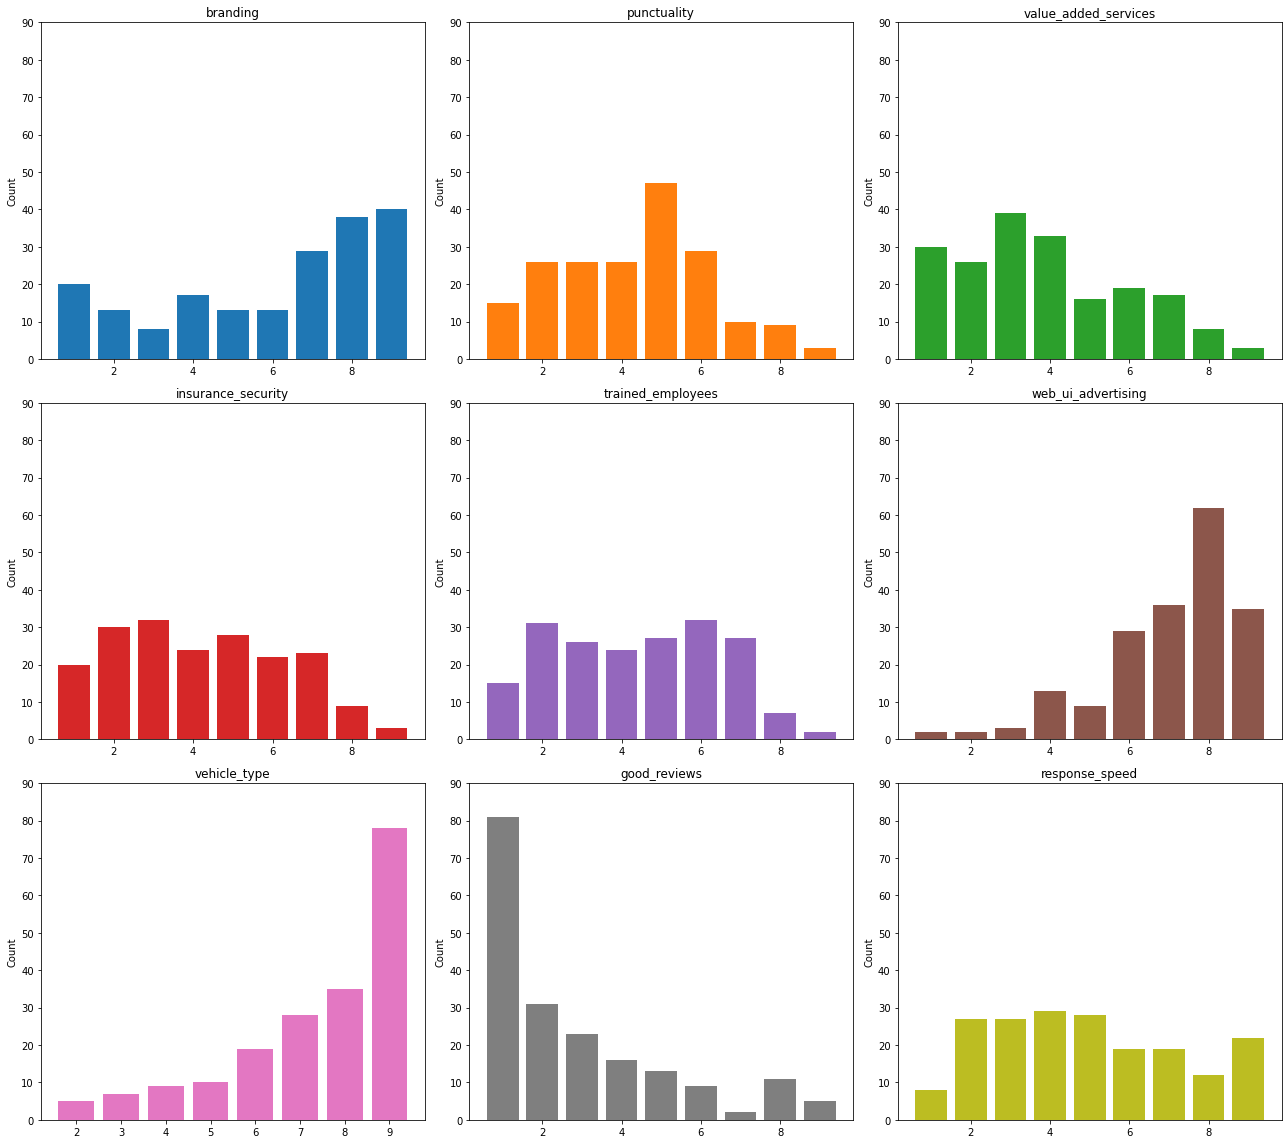

In [8]:
rows = 3
cols = 3

f, axes = plt.subplots(rows, cols, figsize=(18, 16))

for i, col in enumerate([c for c in df.columns if c.startswith('ranked')]):
    r = i//rows
    c = i%cols
    colname = col.split('_', 1)[1]
    
    temp = df[col].value_counts().sort_index()
    
    axes[r,c].bar(x=list(temp.index),
                  height=list(temp.values),
                  color=cm.tab10.colors[i])
    axes[r,c].set_title(colname)
    axes[r,c].set_ylabel('Count')
    axes[r,c].set_ylim(0, 90)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.tight_layout()
plt.show()

### Average Score of Quality Factors

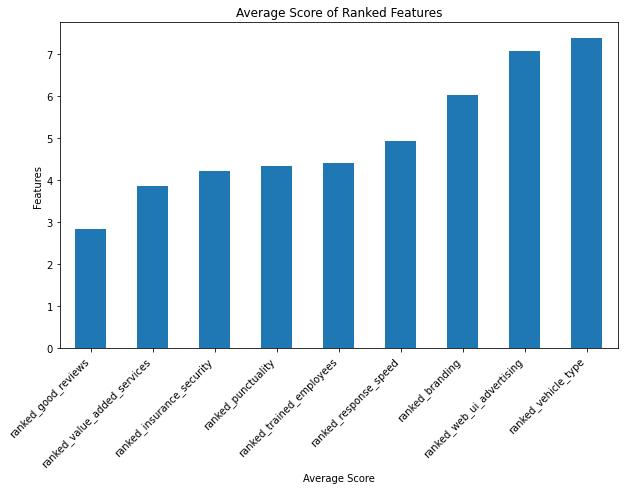

In [9]:
plt.figure(figsize=(10,6))

df[[c for c in df.columns if c.startswith('ranked')]].mean().sort_values().plot.bar(rot=45)
plt.title('Average Score of Ranked Features')
plt.xlabel('Average Score')
plt.ylabel('Features')
plt.xticks(horizontalalignment='right')

plt.show()

### Stratified Responses of Survey Participants

In [10]:
def stratified_age(dataframe, group=0):
    if group == 0:
        temp = dataframe[dataframe['age'] <= 24].copy()
        color = 'red'
        age = "below 25"

    elif group == 1:
        temp = dataframe[(dataframe['age'] > 24) & (dataframe['age'] <= 49)].copy()
        color = 'green'
        age = "25 to 49"

    elif group == 2:
        temp = dataframe[dataframe['age'] >= 50].copy()
        color = 'blue'
        age = "50 and above"
    
    return temp, color, age

def stratified_income(dataframe, group=0):
    if group == 0:
        temp = dataframe[dataframe['annual_income'] == 'Less than 20,000'].copy()
        color = 'red'
        income_group = "less than 20,000"

    elif group == 1:
        temp = dataframe[(dataframe['annual_income'] == '20,000 - 40,000') | 
                         (dataframe['annual_income'] == '40,000 - 60,000') | 
                         (dataframe['annual_income'] == '60,000 - 80,000') | 
                         (dataframe['annual_income'] == '80,000 - 100,000')].copy()
        color = 'green'
        income_group = "between 20,000 and 100,000"
    
    elif group == 2:
        temp = dataframe[(dataframe['annual_income'] == '100,000 - 150,000') | 
                         (dataframe['annual_income'] == 'More than 150,000')].copy()
        color = 'blue'
        income_group = "more than 100,000"
    
    return temp, color, income_group

def plot_subplots(data, stratify='age'):
    features = ['purchased_secondhand_before',
                'willingness_to_purchase_secondhand',
                'purchase_secondhand_from',
                'secondhand_mover_channel',
                'ranked']
    
    plot_width = 30
    plot_height = 10
    
    rows = len(features)
    cols = 3
    
    for row in range(rows):
        f, axes = plt.subplots(1, cols, figsize=(plot_width, plot_height))
        plt.rcParams.update({'font.size': 20})
        col = features[row]
        
        for c in range(cols):
            if stratify=='age':
                temp, color, group = stratified_age(data, group=c)
            elif stratify=='income':
                temp, color, group = stratified_income(data, group=c)
            
            if col in ['purchased_secondhand_before', 'willingness_to_purchase_secondhand']:
                temp2 = temp[col].value_counts().sort_index()
                
#                 axes[c].bar(x=list(temp2.index),
#                             height=list(temp2.values),
#                             color=color)

#                 axes[c].set_title(col + ', \n' + stratify.title() + ' ' + group, fontsize=24)
#                 axes[c].set_xlabel(col, fontsize=18)
#                 axes[c].set_ylabel('Count', fontsize=18)
#                 axes[c].set_xticklabels(list(temp2.index), fontsize=20)

#                 if col=='willingness_to_purchase_secondhand':
#                     axes[c].set_ylim(0, 55)
#                 elif col=='purchased_secondhand_before':
#                     axes[c].set_ylim(0, 80)

                axes[c].pie(list(temp2.values), 
                            labels=list(temp2.index), 
                            autopct='%.2f%%',
                            shadow=True,
                            startangle=90)
                axes[c].set_title(col + ', \n' + stratify.title() + ' ' + group, fontsize=24)
                axes[c].axis('equal')

            elif col in ['purchase_secondhand_from', 'secondhand_mover_channel']:
                all_values = []

                for item in temp[col].values:
                    all_items = item.split(',')
                    for i in all_items:
                        all_values.append(i)

                temp2 = pd.DataFrame(all_values, columns=['value']).value.value_counts().sort_index()

                axes[c].bar(x=list(temp2.index),
                              height=list(temp2.values*100/len(temp)),
                              color=color)

                axes[c].set_title(stratify.title() + ' ' + group, fontsize=24)
                axes[c].set_xlabel(col, fontsize=18)
                axes[c].set_ylabel('Proportion (%)', fontsize=18)
                axes[c].set_xticklabels(list(temp2.index), fontsize=20)
                axes[c].tick_params(axis='x', rotation=45)
                axes[c].set_ylim(0, 100)

                for tick in axes[c].xaxis.get_major_ticks():
                    tick.label1.set_horizontalalignment('right')

            elif col=='ranked':
                temp2 = temp[[c for c in data.columns if c.startswith('ranked')]].mean()
                axes[c].bar(x=list(temp2.index),
                              height=list(temp2.values),
                              color=color)
                axes[c].set_title(stratify.title() + ' ' + group, fontsize=24)
                axes[c].set_xlabel('Quality Factors', fontsize=18)
                axes[c].set_ylabel('Average Score', fontsize=18)
                axes[c].set_ylim(0, 10)
                axes[c].set_xticklabels(list(temp2.index), fontsize=20)
                axes[c].tick_params(axis='x', rotation=45)

                for tick in axes[c].xaxis.get_major_ticks():
                    tick.label1.set_horizontalalignment('right')
        
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.tight_layout()
        plt.show()


#### Analysis by Age

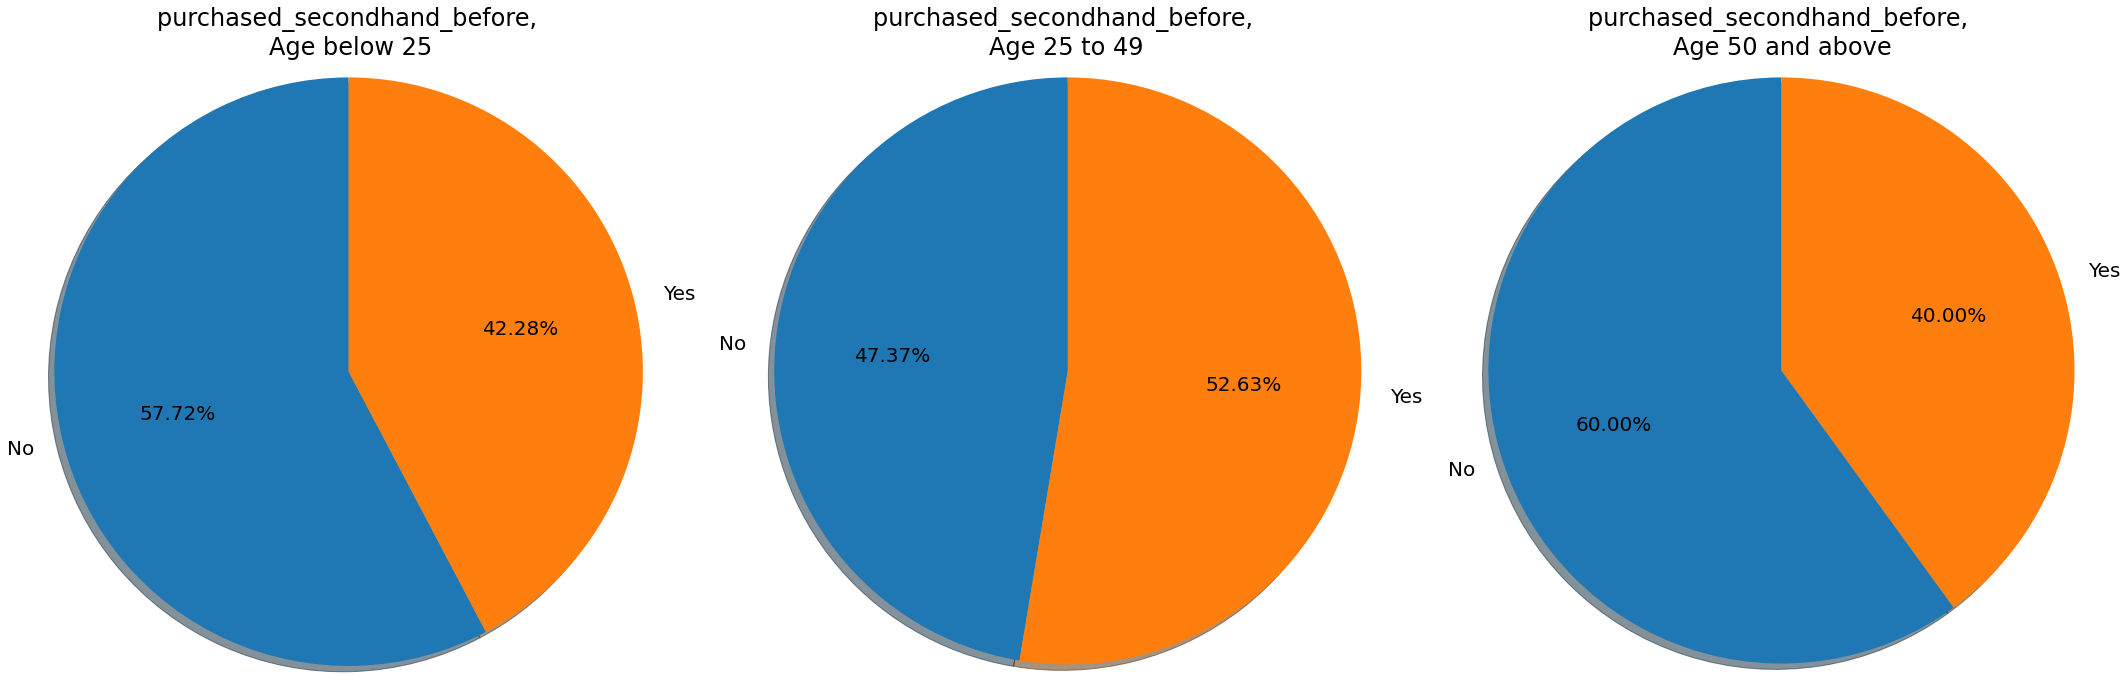

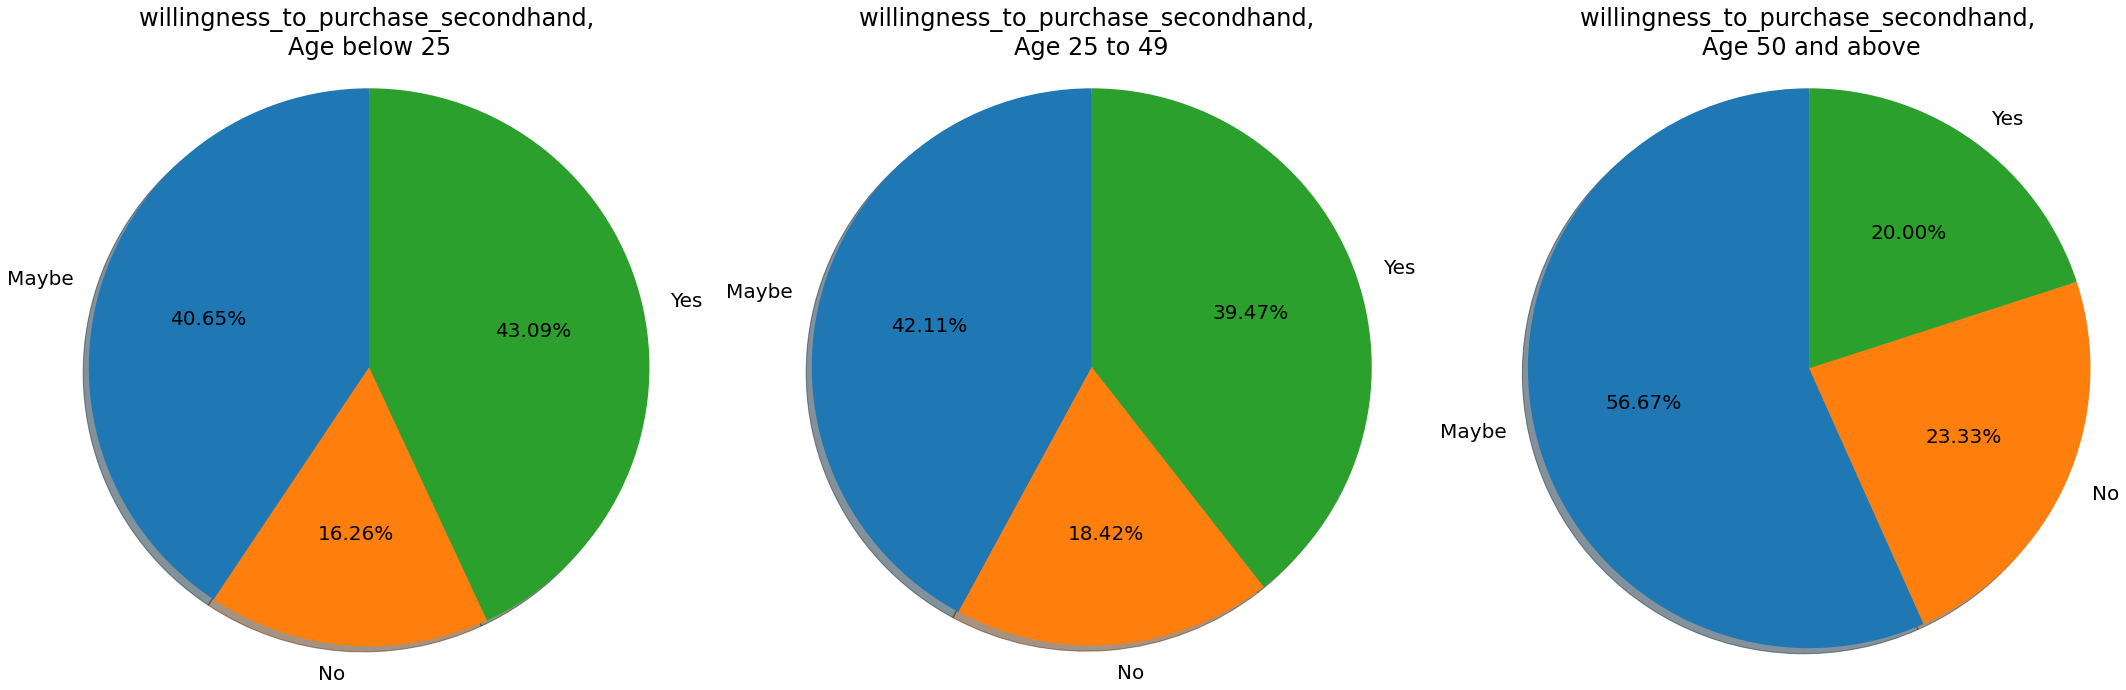

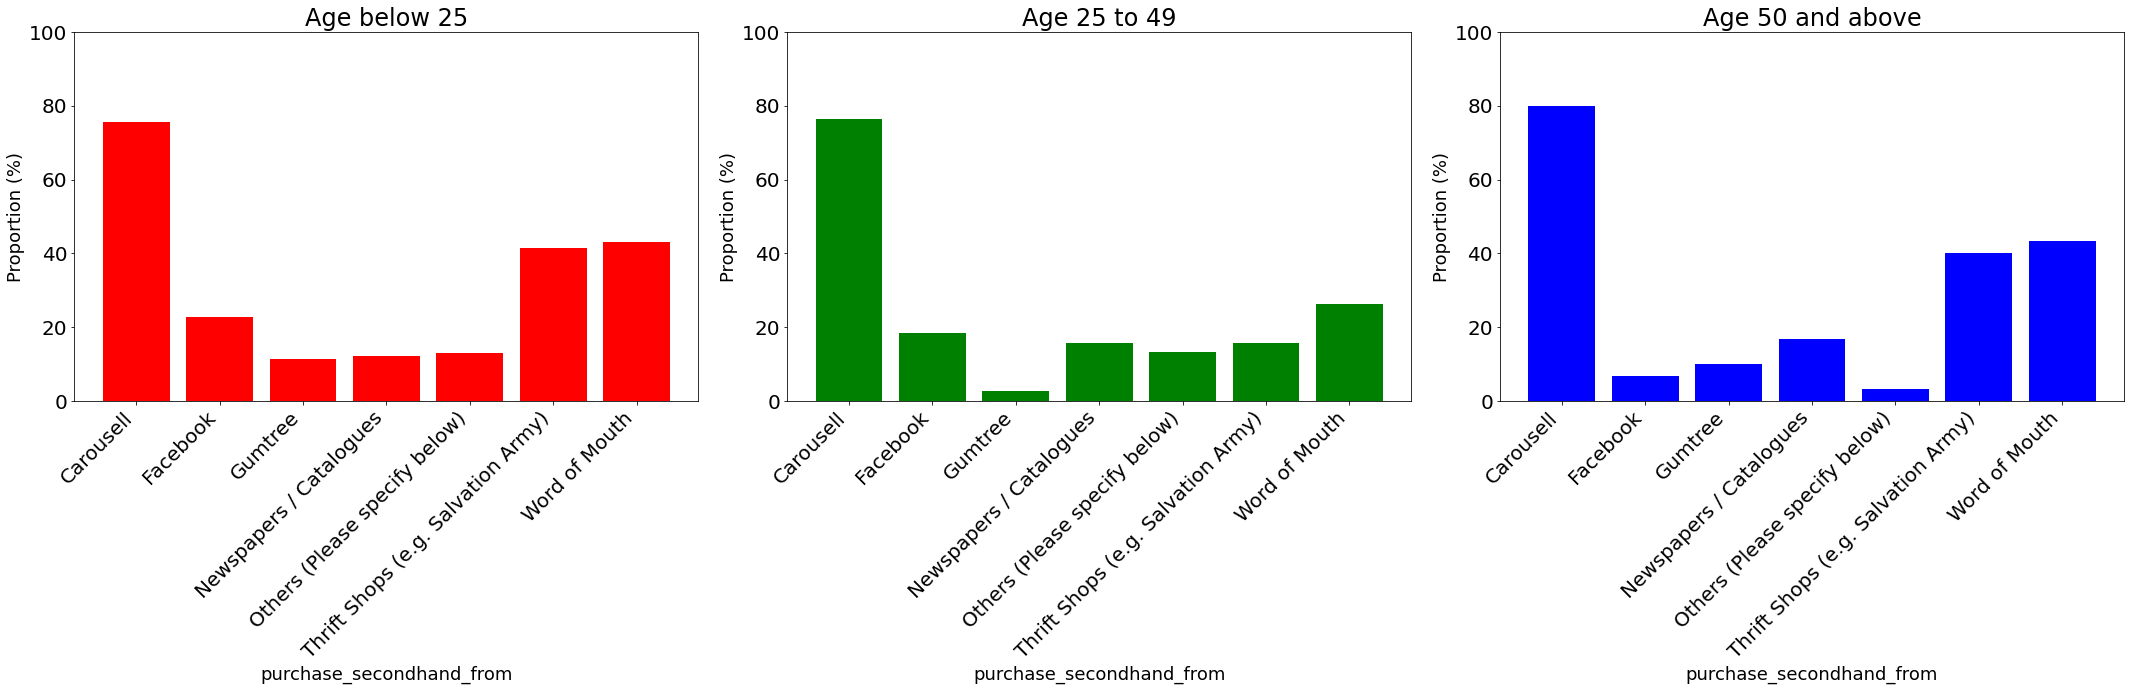

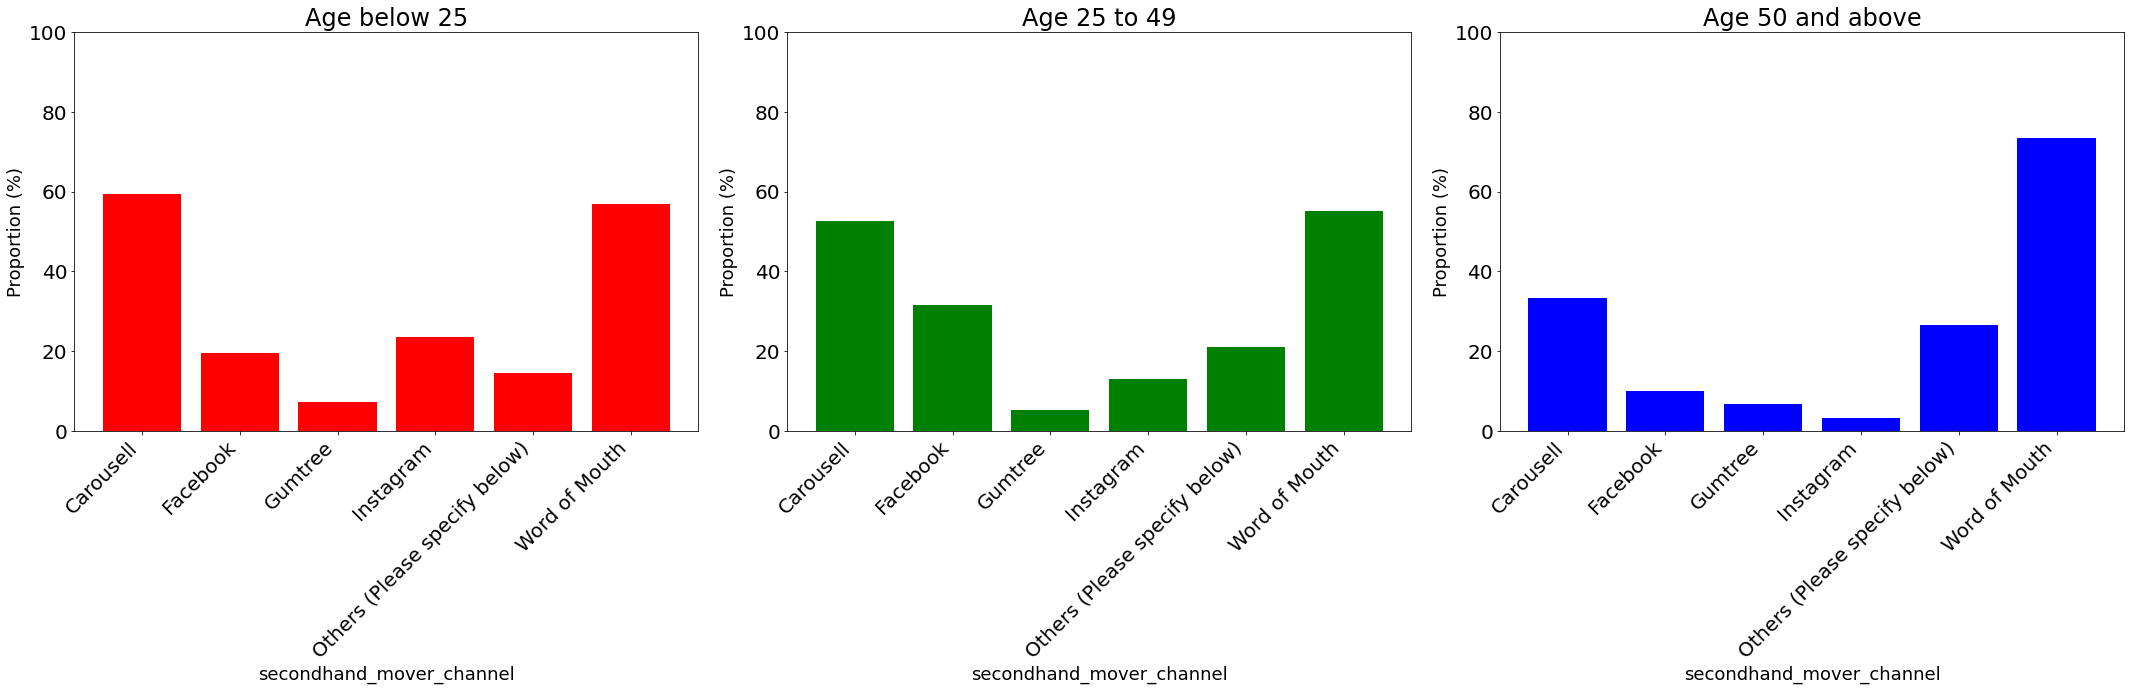

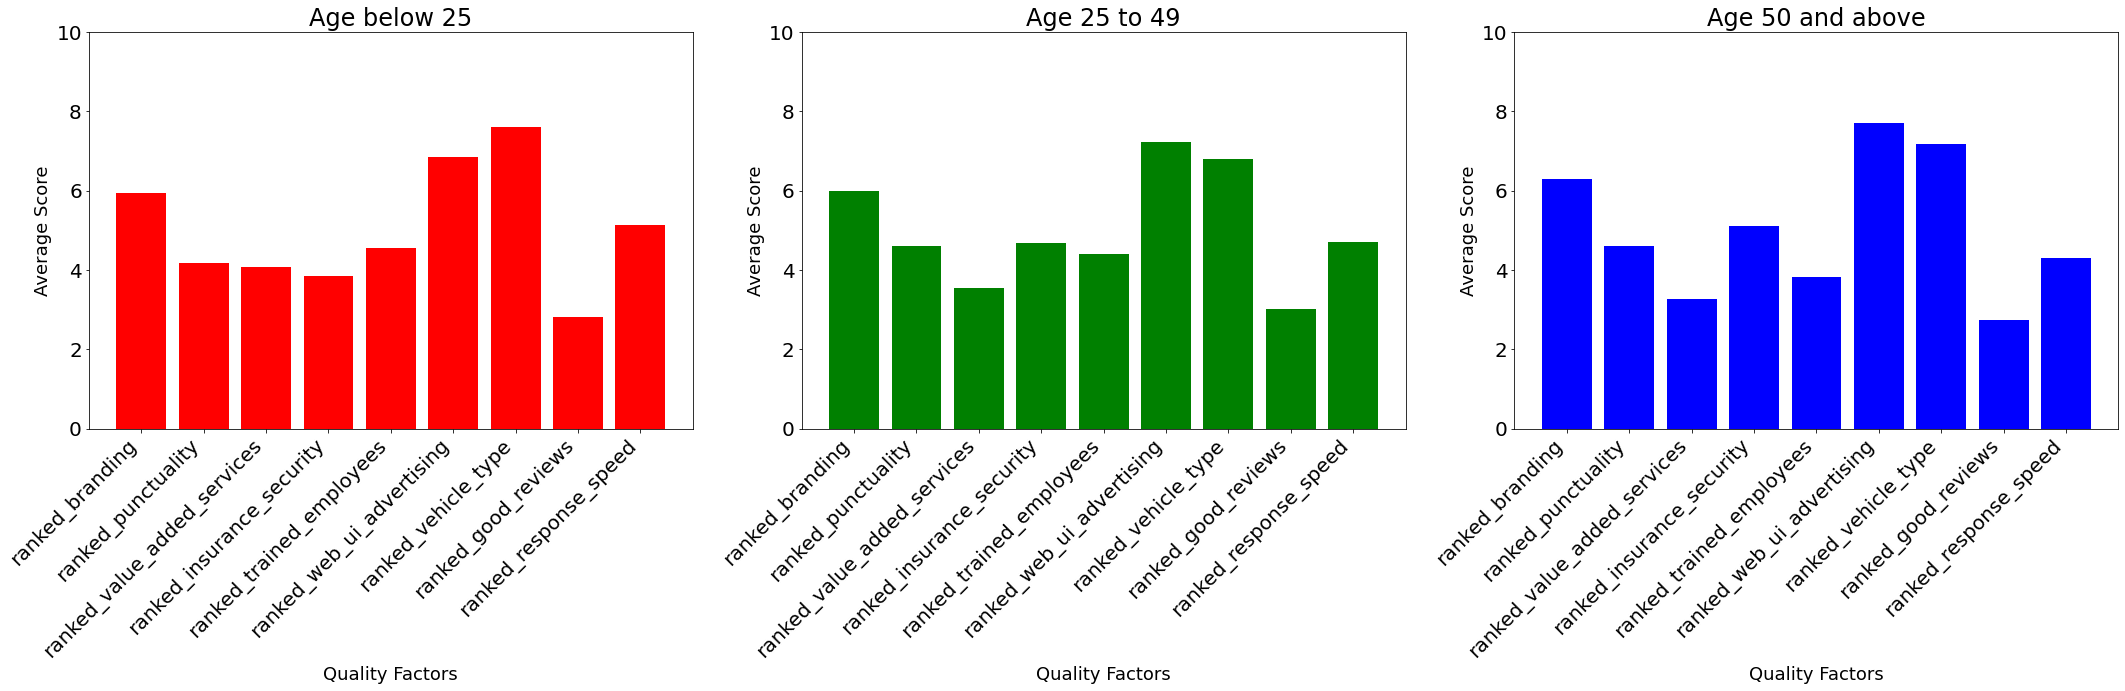

In [11]:
plot_subplots(df, stratify='age')

\***'purchased_secondhand_from'** and **'secondhand_mover_channel'** graphs do not sum up to 100% because each respondent has the option to choose more than one channel for both survey questions

#### Analysis by Income

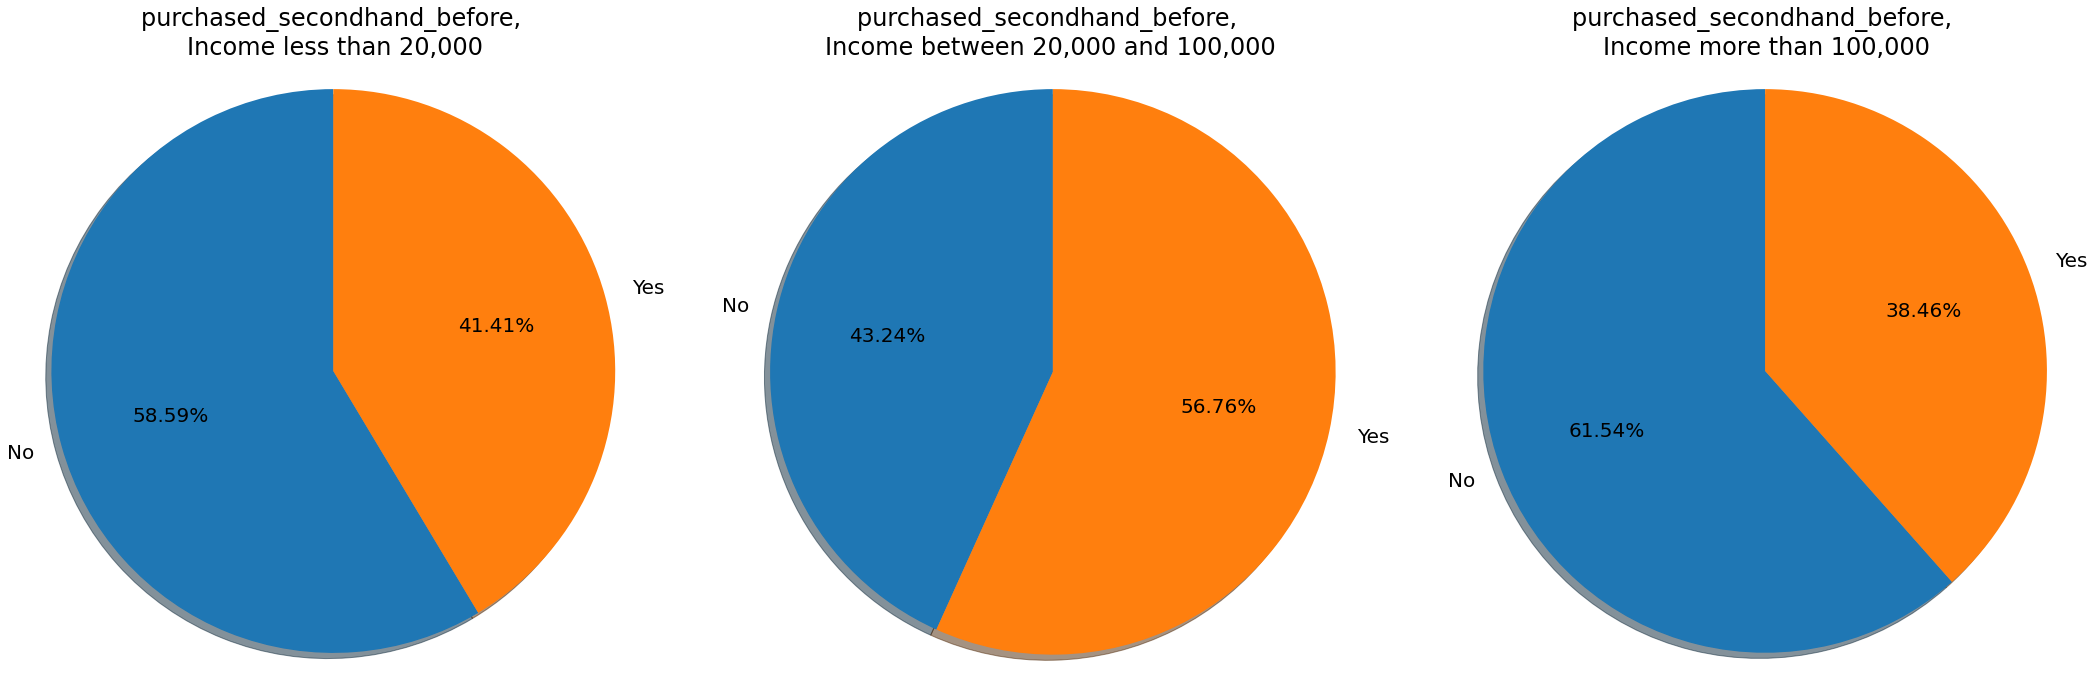

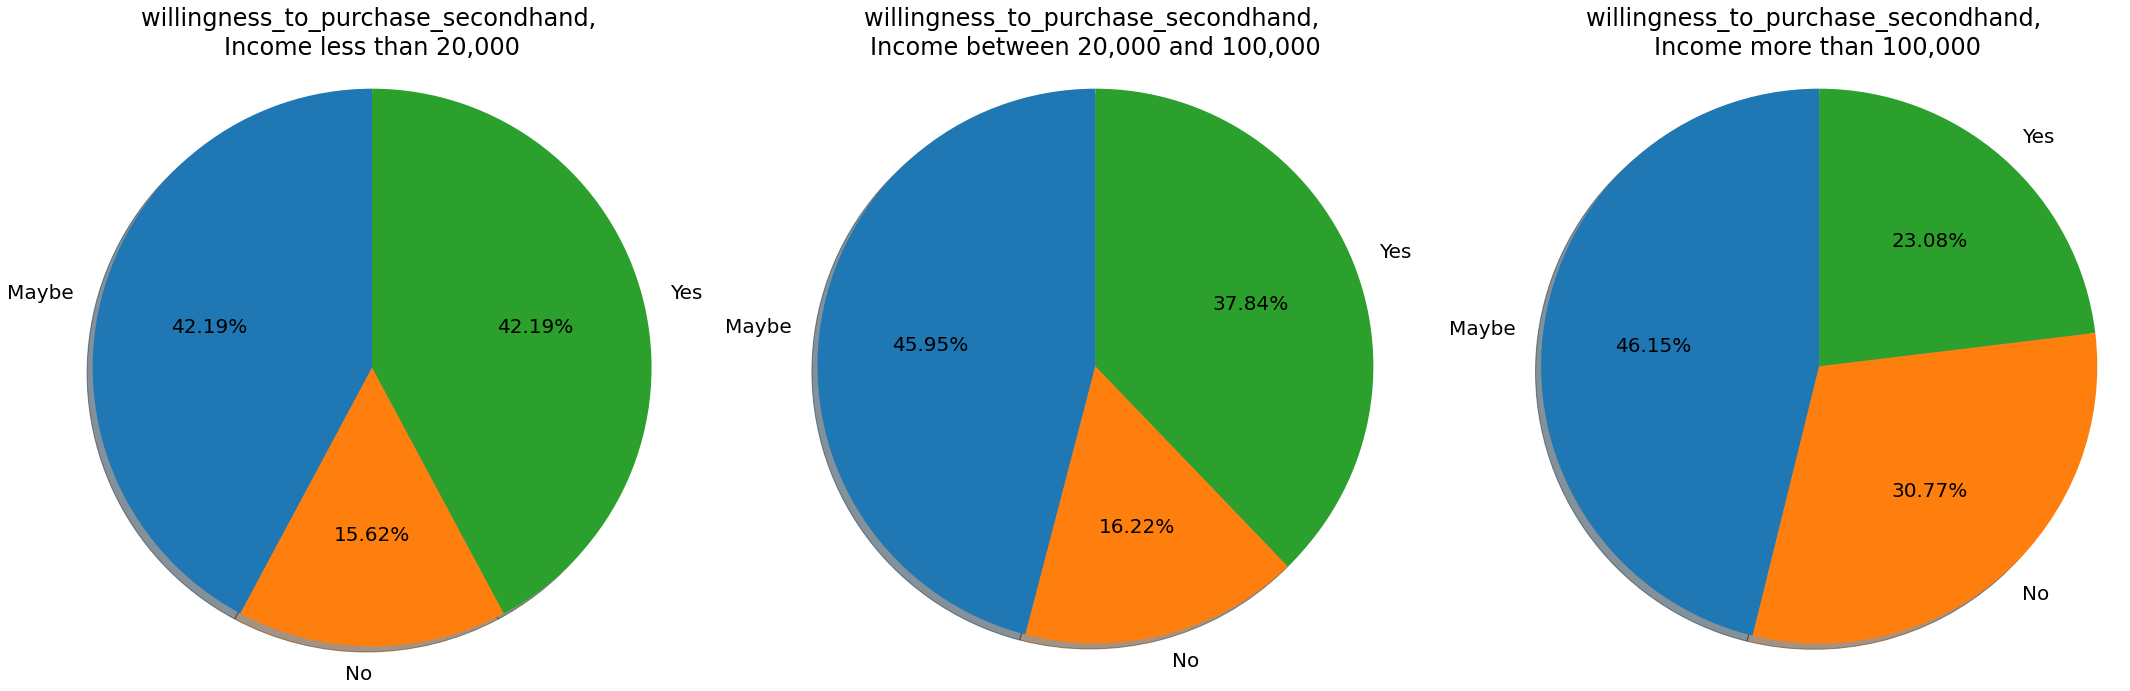

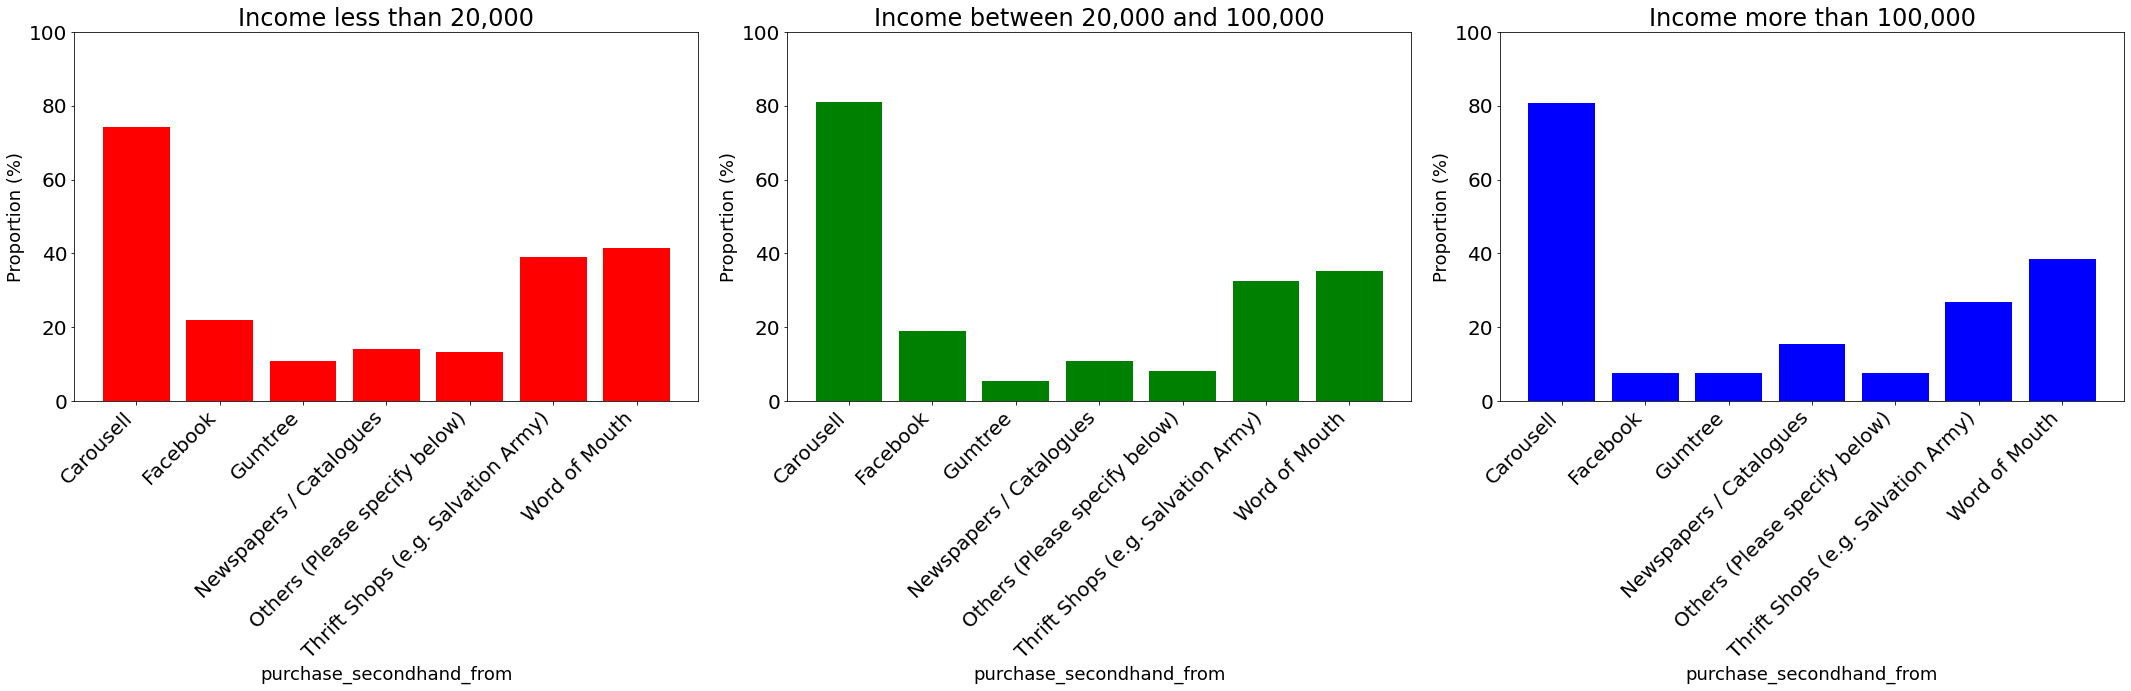

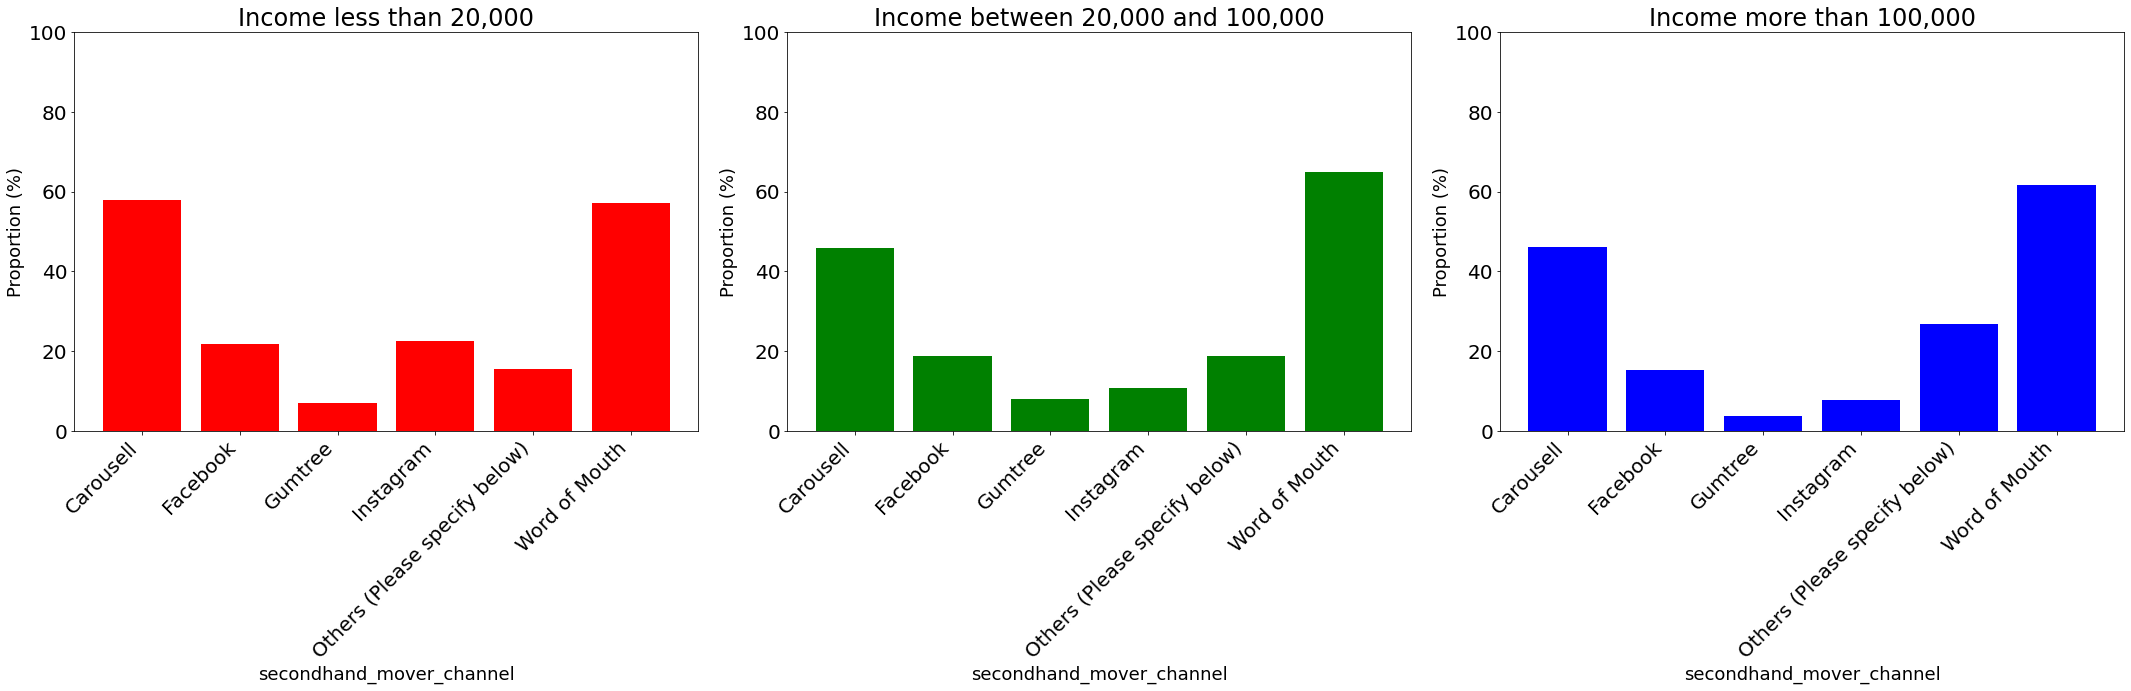

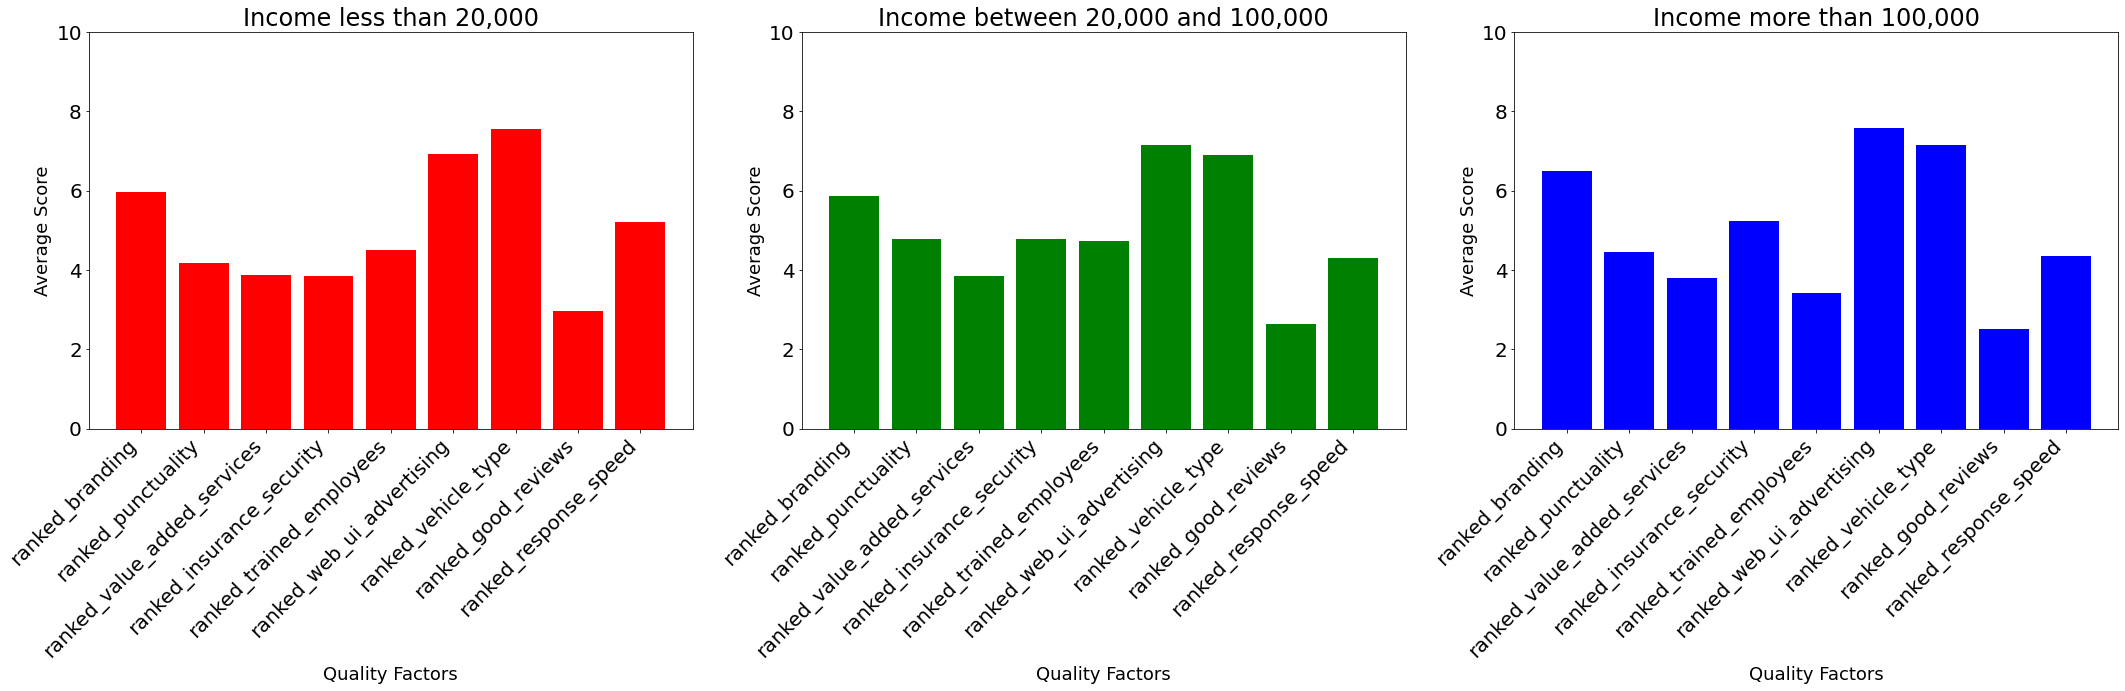

In [12]:
plot_subplots(df, stratify='income')

\***'purchased_secondhand_from'** and **'secondhand_mover_channel'** graphs do not sum up to 100% because each respondent has the option to choose more than one channel for both survey questions

#### Quality Factor Comparison (Table)

In [13]:
comparison = {}

for i in range(3):
    data, color, group = stratified_age(df, group=i)
    temp = data[[c for c in data.columns if c.startswith('ranked')]].mean().sort_values()
    comparison.update({group: temp.index})

print("\n##### Age Group Quality Factor Comparison #####")
    
comparison = pd.DataFrame(comparison)
comparison


##### Age Group Quality Factor Comparison #####


,below 25,25 to 49,50 and above
0,ranked_good_reviews,ranked_good_reviews,ranked_good_reviews
1,ranked_insurance_security,ranked_value_added_services,ranked_value_added_services
2,ranked_value_added_services,ranked_trained_employees,ranked_trained_employees
3,ranked_punctuality,ranked_punctuality,ranked_response_speed
4,ranked_trained_employees,ranked_insurance_security,ranked_punctuality
5,ranked_response_speed,ranked_response_speed,ranked_insurance_security
6,ranked_branding,ranked_branding,ranked_branding
7,ranked_web_ui_advertising,ranked_vehicle_type,ranked_vehicle_type
8,ranked_vehicle_type,ranked_web_ui_advertising,ranked_web_ui_advertising


In [14]:
comparison = {}

for i in range(3):
    data, color, group = stratified_income(df, group=i)
    temp = data[[c for c in data.columns if c.startswith('ranked')]].mean().sort_values()
    comparison.update({group: temp.index})

print("\n##### Income Group Quality Factor Comparison #####")
    
comparison = pd.DataFrame(comparison)
comparison


##### Income Group Quality Factor Comparison #####


,"less than 20,000","between 20,000 and 100,000","more than 100,000"
0,ranked_good_reviews,ranked_good_reviews,ranked_good_reviews
1,ranked_insurance_security,ranked_value_added_services,ranked_trained_employees
2,ranked_value_added_services,ranked_response_speed,ranked_value_added_services
3,ranked_punctuality,ranked_trained_employees,ranked_response_speed
4,ranked_trained_employees,ranked_punctuality,ranked_punctuality
5,ranked_response_speed,ranked_insurance_security,ranked_insurance_security
6,ranked_branding,ranked_branding,ranked_branding
7,ranked_web_ui_advertising,ranked_vehicle_type,ranked_vehicle_type
8,ranked_vehicle_type,ranked_web_ui_advertising,ranked_web_ui_advertising


### Pricing Quality Factors

In [15]:
df_quality = df.loc[:,['additional_amount_for_quality']+[c for c in df.columns if c.startswith('ranked')]]
df_quality

,additional_amount_for_quality,ranked_branding,ranked_punctuality,ranked_value_added_services,ranked_insurance_security,ranked_trained_employees,ranked_web_ui_advertising,ranked_vehicle_type,ranked_good_reviews,ranked_response_speed
0,30.0,7,4,1,5,2,8,6,3,9
1,9.0,4,5,3,6,7,8,2,1,9
2,5.0,9,1,7,3,2,6,4,5,8
3,9.0,5,3,1,6,7,8,9,4,2
4,20.0,7,8,3,2,6,9,4,1,5
...,...,...,...,...,...,...,...,...,...,...
186,15.0,7,5,6,1,3,4,9,2,8
187,10.0,3,6,7,2,1,8,9,4,5
188,1.0,7,2,6,1,3,8,9,4,5
189,2.0,9,4,1,6,2,8,5,3,7


#### One-Hot Encoding & Data Cleaning

In [16]:
cat_vars = [c for c in df.columns if c.startswith('ranked')]

categorical_data = df[cat_vars].copy()
categorical_data.astype('category')

dummy = pd.get_dummies(categorical_data, columns=list(categorical_data.columns))

cleaned_vars = [c for c in dummy.columns if ('1' in c) or ('2' in c) or ('3' in c)]
encode_cleaned = pd.concat([df_quality[['additional_amount_for_quality']], dummy[cleaned_vars]], axis=1)
encode_cleaned['additional_amount_for_quality'] = encode_cleaned['additional_amount_for_quality'].apply(lambda x: x/60)
encode_cleaned

,additional_amount_for_quality,ranked_branding_1,ranked_branding_2,ranked_branding_3,ranked_punctuality_1,ranked_punctuality_2,ranked_punctuality_3,ranked_value_added_services_1,ranked_value_added_services_2,ranked_value_added_services_3,ranked_insurance_security_1,ranked_insurance_security_2,ranked_insurance_security_3,ranked_trained_employees_1,ranked_trained_employees_2,ranked_trained_employees_3,ranked_web_ui_advertising_1,ranked_web_ui_advertising_2,ranked_web_ui_advertising_3,ranked_vehicle_type_2,ranked_vehicle_type_3,ranked_good_reviews_1,ranked_good_reviews_2,ranked_good_reviews_3,ranked_response_speed_1,ranked_response_speed_2,ranked_response_speed_3
0,0.500000,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,0.150000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,0.083333,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0.150000,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.333333,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,0.250000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
187,0.166667,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
188,0.016667,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
189,0.033333,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [17]:
total_ranked = encode_cleaned.agg(['sum']).T
total_ranked.drop(index=['additional_amount_for_quality'], inplace=True)

total_ranked['sum'] = total_ranked['sum'].apply(lambda x: int(x))
total_ranked['proportion'] = total_ranked['sum'] / (total_ranked['sum'].sum()/3)

total_ranked

,sum,proportion
ranked_branding_1,20,0.104712
ranked_branding_2,13,0.068063
ranked_branding_3,8,0.041885
ranked_punctuality_1,15,0.078534
ranked_punctuality_2,26,0.136126
ranked_punctuality_3,26,0.136126
ranked_value_added_services_1,30,0.157068
ranked_value_added_services_2,26,0.136126
ranked_value_added_services_3,39,0.204188
ranked_insurance_security_1,20,0.104712


#### Correlation Plot

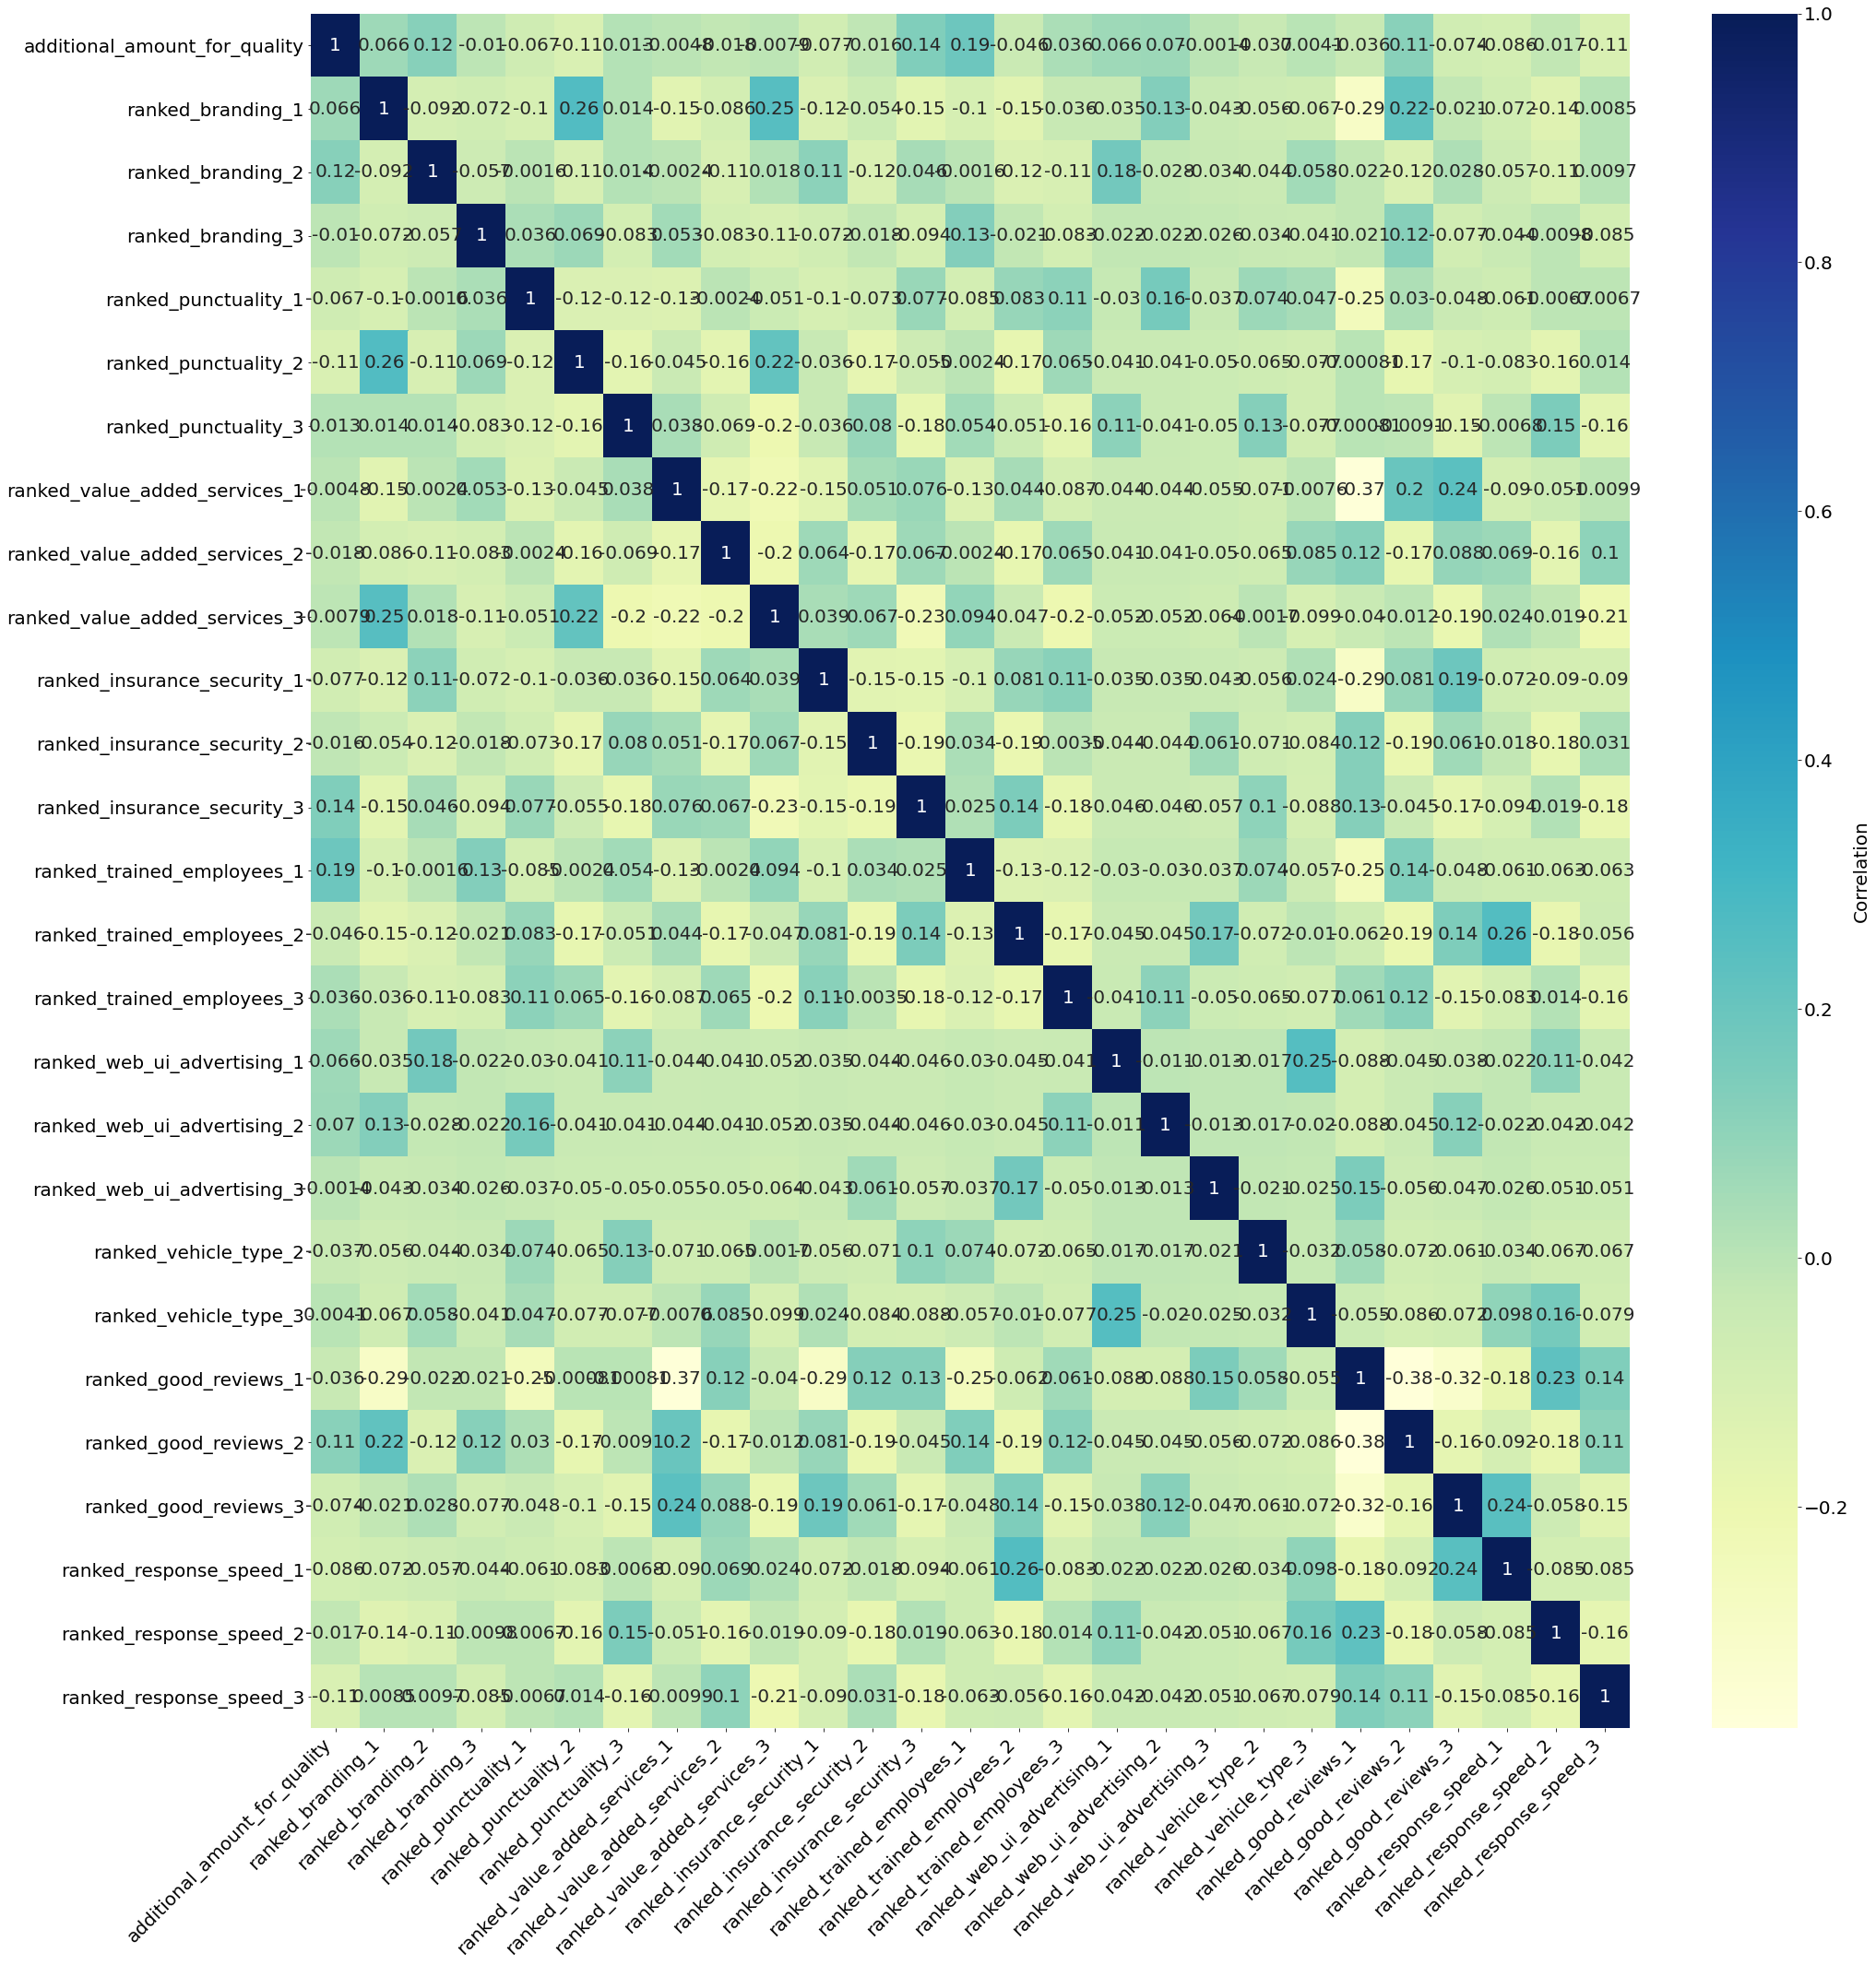

<Figure size 432x288 with 0 Axes>

In [18]:
# Correlation
train_set_duplicated = encode_cleaned.copy()
corr = train_set_duplicated.corr(method='pearson')

plt.figure(figsize=(30,30))
sns.heatmap(corr, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Correlation'})

plt.xticks(rotation=45, horizontalalignment='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()
plt.clf()

#### Model Training

In [19]:
data = encode_cleaned.copy()

X = data.iloc[:,1:]
y = data.iloc[:,0:1]

# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     test_size=0.2,
#                                                     shuffle=True, 
#                                                     random_state=42)

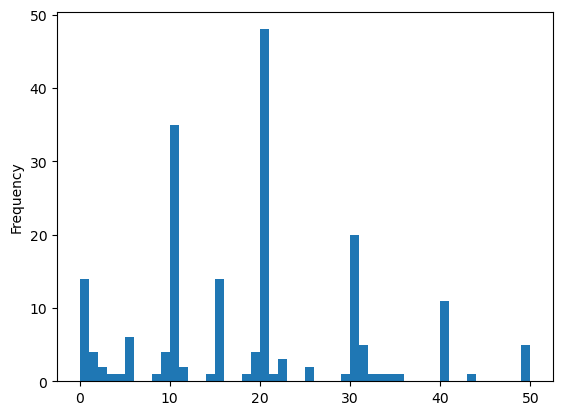

In [20]:
plt.style.use('default')
df_quality.additional_amount_for_quality.plot.hist(bins=50)

#### Verifying Ranked Feature Importance (Indication by Price)

In [21]:
# Random Forest
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X, y)

var_importance = pd.DataFrame({'features': X.columns, 
                               'importance': rfr.feature_importances_})
var_importance.sort_values(by=['importance'], ascending=False, inplace=True)
var_importance.reset_index(drop=True, inplace=True)
var_importance

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


,features,importance
0,ranked_branding_2,0.080216
1,ranked_trained_employees_1,0.068445
2,ranked_good_reviews_3,0.063253
3,ranked_punctuality_3,0.063018
4,ranked_insurance_security_3,0.056224
5,ranked_branding_1,0.055486
6,ranked_punctuality_2,0.052831
7,ranked_good_reviews_1,0.051624
8,ranked_value_added_services_2,0.049857
9,ranked_insurance_security_2,0.043897


In [22]:
temp = var_importance.copy()

def clean_features(data):
    text = data.split('_')
    feature = '_'.join(text[1:-1])
    
    return feature

temp['features'] = temp['features'].apply(clean_features)
temp

,features,importance
0,branding,0.080216
1,trained_employees,0.068445
2,good_reviews,0.063253
3,punctuality,0.063018
4,insurance_security,0.056224
5,branding,0.055486
6,punctuality,0.052831
7,good_reviews,0.051624
8,value_added_services,0.049857
9,insurance_security,0.043897


#### Random Forest Feature Importance Ranked (Not price-related)

In [23]:
temp.groupby(by=['features']).sum().sort_values(by=['importance'], ascending=False)

,importance
features,
branding,0.162990
good_reviews,0.156516
punctuality,0.141275
trained_employees,0.138208
insurance_security,0.135852
value_added_services,0.133210
response_speed,0.072841
vehicle_type,0.032979
web_ui_advertising,0.026130


#### Quality Factor Pricing

In [24]:
# Linear Regression
model_equation = ' + '.join(data.columns).replace('+', '~', 1)

linreg_model = ols(formula=model_equation, data=data).fit()
linreg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     additional_amount_for_quality   R-squared:                       0.140
Model:                                       OLS   Adj. R-squared:                  0.022
Method:                            Least Squares   F-statistic:                     1.186
Date:                           Fri, 09 Oct 2020   Prob (F-statistic):              0.264
Time:                                   11:25:55   Log-Likelihood:                 53.548
No. Observations:                            191   AIC:                            -59.10
Df Residuals:                                167   BIC:                             18.96
Df Model:                                     23                                         
Covariance Type:                       nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.2408      0.024      9.852      0.000       0.193       0.289
ranked_branding_1                 0.0840      0.050      1.668      0.097      -0.015       0.184
ranked_branding_2                 0.1080      0.055      1.977      0.050       0.000       0.216
ranked_branding_3                 0.0060      0.067      0.090      0.929      -0.127       0.139
ranked_punctuality_1             -0.0559      0.052     -1.073      0.285      -0.159       0.047
ranked_punctuality_2             -0.0622      0.044     -1.428      0.155      -0.148       0.024
ranked_punctuality_3              0.0165      0.041      0.408      0.684      -0.063       0.097
ranked_value_added_services_1     0.0126      0.042      0.303      0.762      -0.070       0.095
ranked_value_added_services_2     0.0120      0.042      0.284      0.777      -0.072       0.096
ranked_value_added_services_3     0.0213      0.037      0.578      0.564      -0.051       0.094
ranked_insurance_security_1      -0.0351      0.047     -0.748      0.456      -0.128       0.058
ranked_insurance_security_2       0.0131      0.040      0.326      0.745      -0.066       0.092
ranked_insurance_security_3       0.0877      0.038      2.279      0.024       0.012       0.164
ranked_trained_employees_1        0.1537      0.052      2.943      0.004       0.051       0.257
ranked_trained_employees_2        0.0259      0.041      0.631      0.529      -0.055       0.107
ranked_trained_employees_3        0.0703      0.042      1.669      0.097      -0.013       0.153
ranked_web_ui_advertising_1       0.1085      0.131      0.828      0.409      -0.150       0.367
ranked_web_ui_advertising_2       0.1506      0.131      1.151      0.251      -0.108       0.409
ranked_web_ui_advertising_3       0.0216      0.107      0.202      0.840      -0.190       0.233
ranked_vehicle_type_2            -0.0559      0.083     -0.669      0.504      -0.221       0.109
ranked_vehicle_type_3             0.0462      0.073      0.629      0.530      -0.099       0.191
ranked_good_reviews_1             0.0216      0.035      0.613      0.541      -0.048       0.091
ranked_good_reviews_2             0.0518      0.045      1.160      0.248      -0.036       0.140
ranked_good_reviews_3             0.0021      0.049      0.043      0.965      -0.094       0.098
ranked_response_speed_1          -0.0487      0.070     -0.692      0.490      -0.188       0.090
ranked_response_speed_2          -0.0026      0.043     -0.062      0.951      -0.087       0.082
ranked_response_speed_3          -0.0309      0.041     -0.757      0.450      -0.112       0.050
======================

**Statistically Significant Features:**

1. **trained_employees_1 (Occurs 15 out of 191 times, 7.85%)**: Correlated with willingness to pay an additional of 15.37% of moving service value
2. **branding_2 (Occurs 13 out of 191 times, 6.81%)**: Correlated with willingness to pay an additional of 10.8% of moving service value
3. **insurance_security_3 (Occurs 32 out of 191 times, 16.75%)**: Correlated with willingness to pay an additional of 8.77% of moving service value

\*Willingness to pay only occurs if the ranked factor is important to an individual customer and ranked similarly in their top 3 quality factors, but does not indicate the factors' importance across different customers (refer to previous analysis of ranked quality factors).